In [1]:
import uproot
from uproot_methods.classes import TLorentzVector
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import helpers

In [2]:
rtfile = uproot.open("/eos/cms/store/cmst3/group/hgcal/CMG_studies/kelong/GeantTruthStudy/SimClusterNtuples/test_ExactShoot5PartWPions_seed0_nano.root")

In [3]:
gen = rtfile["Events"].pandas.df(["GenPart*"], flatten=True)
genVtx = rtfile["Events"].pandas.df(["GenVtx*"], flatten=True)
tracking = rtfile["Events"].pandas.df(["Tracking*"], flatten=True)

In [4]:
vtx_x = genVtx.GenVtx_x[0]
vtx_y = genVtx.GenVtx_y[0]
vtx_z = genVtx.GenVtx_z[0]
print(vtx_x, vtx_y, vtx_y)

4.5729394e-09 9.6843e-09 9.6843e-09


In [5]:
gen.GenPart_pt[0][0], gen.GenPart_eta[0][0]

(9.46875, -2.6015625)

In [8]:
import numpy as np
import math

In [81]:
from importlib import reload
reload(helpers)

<module 'helpers' from '/eos/home-k/kelong/SWAN_projects/MLRecoTruth/SimClusterValidation/helpers.py'>

In [17]:
simHitsHGCEE = rtfile["Events"].pandas.df(["SimHitHGCEE*"], flatten=True)
simHitsHGCHEfront = rtfile["Events"].pandas.df(["SimHitHGCHEfront*"], flatten=True)#, entrystart=start, entrystop=start+1)
simHitsHGCHEback = rtfile["Events"].pandas.df(["SimHitHGCHEback*"], flatten=True)#, entrystart=start, entrystop=start+1)
simClusters = rtfile["Events"].pandas.df(["SimCluster*"], flatten=True)
simHitsPixelEC = rtfile["Events"].pandas.df(["SimHitPixelEC*"], flatten=True)
simHitsPixel = rtfile["Events"].pandas.df(["SimHitPixelLowTof*"], flatten=True)
simHitsCSC = rtfile["Events"].pandas.df(["SimHitMuon*"], flatten=True)

In [12]:
colormap = {-1 : 'grey', 111 : "red", 211 : 'blue', 11 : 'green', 13 : 'orange', 22 : "lightblue", 
            2112 : "pink", 2212 : "pink"}

In [94]:
evt = 3
endcap = "-"
pixelec = helpers.hitPositionArray(simHitsPixelEC, "SimHitPixelECLowTof", evt, endcap)
pixel = helpers.hitPositionArray(simHitsPixel, "SimHitPixelLowTof", evt, endcap)
muon = helpers.hitPositionArray(simHitsCSC, "SimHitMuonCSC", evt, endcap)

colors_ec = helpers.colorsFromIds(helpers.idFromHit(simHitsPixelEC, "SimHitPixelECLowTof", evt, endcap))
colors_pix = helpers.colorsFromIds(helpers.idFromHit(simHitsPixel, "SimHitPixelLowTof", evt, endcap))
colors_mu = helpers.colorsFromIds(helpers.idFromHit(simHitsCSC, "SimHitMuonCSC", evt, endcap))

In [52]:
max(pixel[:,2])

119.01826477050781

In [ ]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')

for i in range(0, len(gen.GenPart_pdgId[evt])):
    charge = gen.GenPart_charge[evt][i]
    func = helpers.chargedTrajectory if charge != 0 else helpers.neutralTrajectory
    print(gen.GenPart_pdgId[evt][i], gen.GenPart_pt[evt][i], gen.GenPart_charge[evt][i])
    if (gen.GenPart_eta[evt][i] > 0 and endcap == "-") or (gen.GenPart_eta[evt][i] < 0 and endcap == "+"):
        continue
    pdgid = gen.GenPart_pdgId[evt][i]
    vertex = np.array([genVtx.GenVtx_x[evt], genVtx.GenVtx_y[evt], genVtx.GenVtx_z[evt]])
    momentum = np.array([gen.GenPart_pt[evt][i]*math.cos(gen.GenPart_phi[evt][i]), 
                        gen.GenPart_pt[evt][i]*math.sin(gen.GenPart_phi[evt][i]), 
                        gen.GenPart_pt[evt][i]*math.sinh(gen.GenPart_eta[evt][i])])
    endz = 500 if momentum[2] > 0 else -500
    points = func(vertex, momentum, endz, charge)
    color = colormap[abs(pdgid)]
    ax.plot(points[:,2], points[:,0], points[:,1], c=color)
    
simhitsEE = helpers.simHitsAndClusters(simHitsHGCEE[simHitsHGCEE.SimHitHGCEE_z < 0], "SimHitHGCEE", simClusters, evt)
simhitsHEfront = helpers.simHitsAndClusters(simHitsHGCHEfront[simHitsHGCHEfront.SimHitHGCHEfront_z < 0], "SimHitHGCHEfront", simClusters, evt)
simhitsHEback = helpers.simHitsAndClusters(simHitsHGCHEback[simHitsHGCHEback.SimHitHGCHEback_z < 0], "SimHitHGCHEback", simClusters, evt)
nsc = len(simClusters.SimCluster_pdgId[evt])

for i in range(-1, nsc):
    pdgid = abs(simClusters.SimCluster_pdgId[evt,i]) if i >= 0 else -1
    color = colormap[pdgid] if pdgid > 0 else 'lightgrey'
    ax.scatter(simhitsEE[i,:,2], simhitsEE[i,:,0], simhitsEE[i,:,1], marker='o', c=color, s=1)
    ax.scatter(simhitsHEfront[i,:,2], simhitsHEfront[i,:,0], simhitsHEfront[i,:,1], marker='o', c=color, s=1)
    ax.scatter(simhitsHEback[i,:,2], simhitsHEback[i,:,0], simhitsHEback[i,:,1], marker='o', c=color, s=1)

ax.scatter(pixel[:,2], pixel[:,0], pixel[:,1], marker='o', c=colors_pix, s=1)
ax.scatter(pixelec[:,2], pixelec[:,0], pixelec[:,1], marker='o', c=colors_ec, s=1)
ax.scatter(muon[:,2], muon[:,0], muon[:,1], marker='o', c=colors_mu, s=1)    
    
zlim = [-1000,1000]
if endcap == "+":
    zlim = [0, 1000]
elif endcap == "-":
    zlim = [-1000, 0]
ax.set_xlim3d(*zlim)
ax.set_ylim3d(-150,150)
ax.set_zlim3d(-150,150)
ax.set_xlabel('z pos')
ax.set_ylabel('x pos')
ax.set_zlabel('y pos')

22 1.90625 0
-11 9.03125 1
13 9.4375 -1
211 31.125 1
111 2.96875 0
22 3.4453125 0
-11 24.9375 1
13 6.4375 -1
211 14.40625 1
111 11.1875 0
6171 45
298 45
1381 45


Text(0.5, 0, 'y pos')

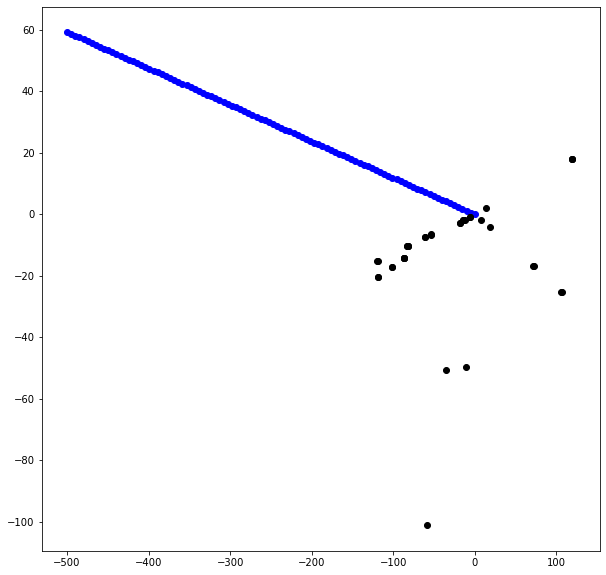

In [60]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.scatter(points[:,2], points[:,0], color='blue')
ax.scatter(pixel[:,2], pixel[:,0], color='black')

In [87]:
for i in range(0, 10):
    pdgid = gen.GenPart_pdgId[evt][i]
    pt = gen.GenPart_pt[evt][i]
    print (pdgid, pt)

22 14.96875
-11 15.71875
13 25.0
211 5.890625
111 3.1328125
22 7.375
-11 21.0625
13 12.90625
211 11.09375
111 20.8125
